In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 252, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 126, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,177 (180.38 KB)

 Trainable params: 46,177 (180.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.5209 - loss: 0.6931 - val_accuracy: 0.5855 - val_loss: 0.6769 - learning_rate: 0.0010
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5804 - loss: 0.6773 - val_accuracy: 0.5682 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5592 - loss: 0.6837 - val_accuracy: 0.5391 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5529 - loss: 0.6871 - val_accuracy: 0.6023 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5836 - loss: 0.6733 - val_accuracy: 0.5824 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6105 - loss: 0.6582 - val_accuracy: 0.7281 - val_loss: 0.5617 - learning_rate: 0.0010
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6316 - los

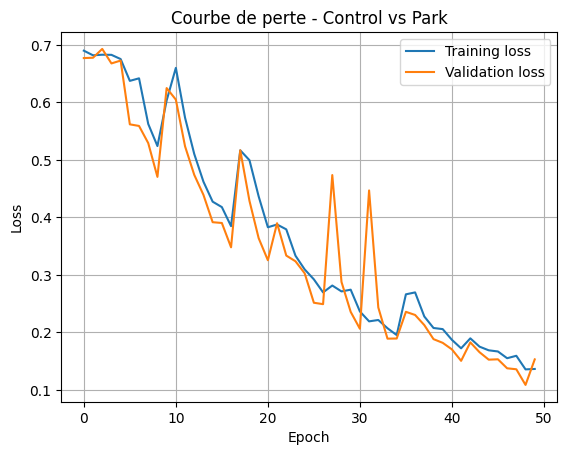

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# === PARAMÈTRES ===
base_path = '/content/drive/MyDrive/Classification_data'
window_size = 256
step_size = 128
max_len = window_size

# === FONCTIONS ===

def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def load_data_by_group(data_dir, group_name, label):
    X, y = [], []
    files = sorted([f for f in os.listdir(data_dir) if group_name in f and f.endswith('.csv')])
    for fname in files:
        df = pd.read_csv(os.path.join(data_dir, fname))
        if 'left_signal' not in df.columns or 'right_signal' not in df.columns:
            continue
        left = normalize_signal(df['left_signal'].values)
        right = normalize_signal(df['right_signal'].values)
        combined = np.stack([left, right], axis=1)

        for i in range(0, len(combined) - window_size, step_size):
            window = combined[i:i + window_size]
            X.append(window)
            y.append(label)
    return np.array(X), np.array(y)

# === CHARGEMENT DES DONNÉES ===
X_control, y_control = load_data_by_group(base_path, 'control', 0)
X_park, y_park = load_data_by_group(base_path, 'park', 1)

X = np.concatenate([X_control, X_park], axis=0)
y = np.concatenate([y_control, y_park], axis=0)

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODÈLE CNN + LSTM ===

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model((max_len, 2))
model.summary()

# === CALLBACK ===
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# === ENTRAÎNEMENT ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler],
    verbose=1
)

# === ÉVALUATION ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy (Control vs Park): {test_acc:.2f}")

# === COURBE DE PERTE ===
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de perte - Control vs Park")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Affichage des métriques
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-score: {f1:.2f}")

# Rapport détaillé
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Control", "PARK"]))


152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Test Accuracy: 0.94
Test Recall: 0.92
Test F1-score: 0.94

Classification Report:
              precision    recall  f1-score   support

     Control       0.93      0.95      0.94      2486
        PARK       0.95      0.92      0.94      2361

    accuracy                           0.94      4847
   macro avg       0.94      0.94      0.94      4847
weighted avg       0.94      0.94      0.94      4847



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 252, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 126, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,177 (180.38 KB)

 Trainable params: 46,177 (180.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7378 - loss: 0.5789 - val_accuracy: 0.7373 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 2/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7407 - loss: 0.5715 - val_accuracy: 0.7373 - val_loss: 0.5737 - learning_rate: 0.0010
Epoch 3/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7403 - loss: 0.5720 - val_accuracy: 0.7373 - val_loss: 0.5653 - learning_rate: 0.0010
Epoch 4/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7358 - loss: 0.5780 - val_accuracy: 0.7373 - val_loss: 0.5712 - learning_rate: 0.0010
Epoch 5/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7421 - loss: 0.5417 - val_accuracy: 0.7675 - val_loss: 0.4895 - learning_rate: 0.0010
Epoch 6/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7699 - loss: 0.4854 - val_accuracy: 0.7767 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 7/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7988 - l

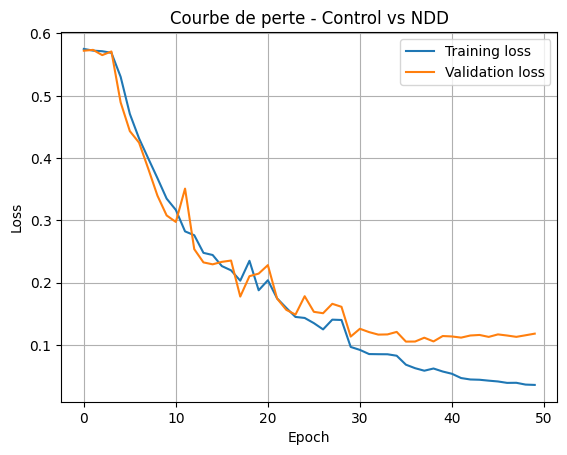

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# === PARAMÈTRES ===
base_path = '/content/drive/MyDrive/Classification_data'
window_size = 256
step_size = 128
max_len = window_size

# === FONCTIONS ===

def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def load_data_by_group(data_dir, group_name, label):
    X, y = [], []
    files = sorted([f for f in os.listdir(data_dir) if group_name in f and f.endswith('.csv')])
    for fname in files:
        df = pd.read_csv(os.path.join(data_dir, fname))
        if 'left_signal' not in df.columns or 'right_signal' not in df.columns:
            continue
        left = normalize_signal(df['left_signal'].values)
        right = normalize_signal(df['right_signal'].values)
        combined = np.stack([left, right], axis=1)

        for i in range(0, len(combined) - window_size, step_size):
            window = combined[i:i + window_size]
            X.append(window)
            y.append(label)
    return np.array(X), np.array(y)

# === CHARGEMENT DES DONNÉES ===
X_control, y_control = load_data_by_group(base_path, 'control', 0)
X_als, y_als = load_data_by_group(base_path, 'als', 1)
X_park, y_park = load_data_by_group(base_path, 'park', 1)
X_hunt, y_hunt = load_data_by_group(base_path, 'hunt', 1)

# === CONCATÉNER CONTROL vs NDD ===
X = np.concatenate([X_control, X_als, X_park, X_hunt], axis=0)
y = np.concatenate([y_control, y_als, y_park, y_hunt], axis=0)

# === MÉLANGE ET SÉPARATION ===
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODÈLE CNN + LSTM ===

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model((max_len, 2))
model.summary()

# === CALLBACK ===
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# === ENTRAÎNEMENT ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler],
    verbose=1
)

# === ÉVALUATION ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy (Control vs NDD): {test_acc:.2f}")

# === COURBE DE PERTE ===
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de perte - Control vs NDD")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

# Prédictions sur l'ensemble de test
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Affichage des métriques
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-score: {f1:.2f}")

# Rapport détaillé
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Control", "NDD"]))


299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Test Accuracy: 0.97
Test Recall: 0.98
Test F1-score: 0.98

Classification Report:
              precision    recall  f1-score   support

     Control       0.93      0.93      0.93      2489
         NDD       0.98      0.98      0.98      7073

    accuracy                           0.97      9562
   macro avg       0.96      0.96      0.96      9562
weighted avg       0.97      0.97      0.97      9562

